In [1]:
!pip install -q underthesea
!pip install -q rouge-score
!pip install -q flash_attn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.9/20.9 MB 86.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 657.8/657.8 kB 25.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 47.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 51.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 30.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 20.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not c

# Import thư viện

In [2]:
import json
import os
import pandas as pd
import re
import string
import numpy as np
import pickle
import torch.nn as nn
from underthesea import word_tokenize, text_normalize
import random
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import spacy
from collections import Counter
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from torch.utils.data import Dataset, DataLoader
import torch
import torchvision.models as models
from torchvision.models import resnet50, ResNet50_Weights
import torch.nn.functional as F
import math
import logging
import time
from torch.optim import AdamW
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from rouge_score import rouge_scorer
from transformers import AutoModel, CLIPImageProcessor

2025-05-18 14:54:51.224207: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747580091.643425      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747580091.769012      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Import dữ liệu

In [3]:
df_train = pd.read_csv("/kaggle/input/data-nlp-bai-2/df_train.csv")
df_train = df_train.sort_values(by=["image_id"])
# df_train = df_train.iloc[:100]
df_all = df_train.copy()
df_all

,index,image_id,question,answer,image_path
232225,161725,0,ai là người chủ biên_phần tiếng việt của cuốn ...,người chịu trách_nhiệm biên_soạn chính phần ti...,/kaggle/input/data-nlp-bai-2/img/img/0.jpg
110289,130595,0,người nào đóng vai_trò chủ_chốt trong việc biê...,bùi_minh toàn là người chủ biên_phần tiếng việ...,/kaggle/input/data-nlp-bai-2/img/img/0.jpg
25090,149975,0,cuốn sách được in lần thứ mấy,cuốn sách được in lần thứ ba,/kaggle/input/data-nlp-bai-2/img/img/0.jpg
123548,149976,0,ai là người chủ biên_phần tiếng việt của cuốn ...,bùi_minh toàn là người chủ biên_phần tiếng việ...,/kaggle/input/data-nlp-bai-2/img/img/0.jpg
20730,161724,0,ai là người chủ biên_phần tiếng việt của cuốn ...,bùi_minh toàn đảm_nhiệm vai_trò chủ_biên_phần ...,/kaggle/input/data-nlp-bai-2/img/img/0.jpg
...,...,...,...,...,...
180060,259050,51854,trong bức ảnh tình_huống 1 diễn_tả cuộc trò_ch...,tình_huống 1 mô_tả cuộc trò_chuyện giữa hưng b...,/kaggle/input/data-nlp-bai-2/img/img/51854.jpg
56024,259057,51855,hình_ảnh minh_họa cho câu hỏi 1 là gì,hình_ảnh minh_họa cho câu hỏi 1 là 4 khung_tho...,/kaggle/input/data-nlp-bai-2/img/img/51855.jpg
127299,259055,51855,câu hỏi 1 đề_cập đến vấn_đề gì,câu hỏi 1 đề_cập đến khả_năng lưu_trữ văn_bản ...,/kaggle/input/data-nlp-bai-2/img/img/51855.jpg
185552,259056,51855,câu hỏi 2 đề_cập đến các biện_pháp bảo_vệ dữ_l...,câu hỏi 2 đề_cập đến 5 biện_pháp bảo_vệ dữ_liệ...,/kaggle/input/data-nlp-bai-2/img/img/51855.jpg


In [4]:
df_test = pd.read_csv("/kaggle/input/data-nlp-bai-2/df_test.csv")
df_test = df_test.sort_values(by=["image_id"])
# df_test = df_test.iloc[:100]
df_test

,index,image_id,question,answer,image_path
27607,149973,0,cuốn sách trong ảnh thuộc bộ_môn_học nào,cuốn sách trong ảnh thuộc bộ_môn_ngữ văn,/kaggle/input/data-nlp-bai-2/img/img/0.jpg
29021,149977,0,cuốn sách do đơn_vị nào xuất_bản,cuốn sách được xuất_bản bởi nhà_xuất_bản giáo_...,/kaggle/input/data-nlp-bai-2/img/img/0.jpg
29207,130596,0,nhà_xuất_bản nào phát_hành cuốn sách này,cuốn sách được xuất_bản bởi nhà_xuất_bản giáo_...,/kaggle/input/data-nlp-bai-2/img/img/0.jpg
59296,149974,0,cuốn sách dành cho học_sinh lớp nào,cuốn sách dành cho học_sinh lớp 12,/kaggle/input/data-nlp-bai-2/img/img/0.jpg
58907,130598,1,ví_dụ 2 câu a chỉ ra số phức nào có giá_trị tu...,câu a cho biết số phức 2 cos0 isin0 có modun b...,/kaggle/input/data-nlp-bai-2/img/img/1.jpg
...,...,...,...,...,...
42900,259030,51850,tập_nghiệm của bất_phương trình x 3 được biểu_...,tập_nghiệm của bất_phương trình x 3 là tập_hợp...,/kaggle/input/data-nlp-bai-2/img/img/51850.jpg
48334,259033,51850,hướng_dẫn cách biểu_diễn tập_nghiệm của bất_ph...,để biểu_diễn tập_nghiệm của bất_phương trình x...,/kaggle/input/data-nlp-bai-2/img/img/51850.jpg
7790,259042,51852,số 12 324 được tạo thành từ các đơn_vị nào,số 12 324 được tạo thành từ 1 chục nghìn 2 ngh...,/kaggle/input/data-nlp-bai-2/img/img/51852.jpg
16617,259048,51853,trong đoạn văn_bản thứ ba tác_giả miêu_tả việc...,tác_giả miêu_tả mi uống rượu một_cách say_sưa ...,/kaggle/input/data-nlp-bai-2/img/img/51853.jpg


# Tạo tập từ vựng

In [5]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),

    #Thêm 1 vài bước xử lý ảnh để đa dạng hóa dữ liệu - Data Augmentation
    transforms.RandomRotation(30),  # Xoay ảnh ngẫu nhiên trong khoảng ±30 độ
    transforms.RandomHorizontalFlip(),  # Lật ngang ngẫu nhiên
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Điều chỉnh độ sáng, độ tương phản
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) 
])

In [6]:
nlp = spacy.load("en_core_web_sm")

In [7]:
#Tokenizer sử dụng spacy
def spacy_tokenizer(text):
    tokens = []
    for token in nlp(text):
        if not token.is_punct and not token.is_space: # Nếu không phải là dấu câu hoặc là khoảng trống thì thêm vào tokens
            tokens.append(token.text.lower())
    return tokens # Trả về mảng có chứa các chữ trong câu

In [8]:
#Xây dựng vocab cho bài toán
def build_vocab(texts, min_freq = 1):
    """
    texts: danh sách các câu hỏi hoặc trả lời được đưa vào
    min_freq: Tần suất tối thiểu 1 chữ xuất hiện để đưa vào vocab
    """
    counter = Counter()
    for text in texts:
        counter.update(spacy_tokenizer(text)) #Counter để đếm xem 1 chữ xuất hiện bao nhiêu lần
    # print(counter)

    vocab = {}
    vocab["<unk>"] = 0  # Token unknown
    vocab["<pad>"] = 1  # Token padding
    vocab["<sos>"] = 2  # Start of sentence
    vocab["<eos>"] = 3  # End of sentence
    
    index = 4 #Bắt đầu từ 2 do 0 với 1 dành cho <UNK>, <PAD>
    for word, freq in counter.items():
        if freq >= min_freq:
            vocab[word] = index
            index += 1
    # print(vocab)
    return vocab

In [9]:
# vocab_questions = build_vocab(df_all['question'])
with open("/kaggle/input/model-vqa-nlp-bai-2/model_define/vocab_question.pkl", "rb") as f:
    vocab_questions = pickle.load(f)

In [10]:
# with open("vocab_question.pkl", 'wb') as f:
#     pickle.dump(vocab_questions, f)

In [11]:
# vocab_answers = build_vocab(df_all['answer'])
with open("/kaggle/input/model-vqa-nlp-bai-2/model_define/vocab_answers.pkl", "rb") as f:
    vocab_answers = pickle.load(f)

In [12]:
# with open("vocab_answers.pkl", 'wb') as f:
#     pickle.dump(vocab_answers, f)

In [13]:
# Kiểm tra một số từ trong vocab
print("Sample vocab from questions:")
for word, index in list(vocab_questions.items())[:10]:  # Hiển thị 10 từ đầu tiên
    print(f"{word}: {index}")

print("\nSample vocab from answers:")
for word, index in list(vocab_answers.items())[:10]:  # Hiển thị 10 từ đầu tiên
    print(f"{word}: {index}")

Sample vocab from questions:
<unk>: 0
<pad>: 1
<sos>: 2
<eos>: 3
ai: 4
là: 5
người: 6
chủ: 7
biên_phần: 8
tiếng: 9

Sample vocab from answers:
<unk>: 0
<pad>: 1
<sos>: 2
<eos>: 3
người: 4
chịu: 5
trách_nhiệm: 6
biên_soạn: 7
chính: 8
phần: 9


In [14]:
# Lấy kích thước của các vocab
questions_vocab_size = len(vocab_questions)
answers_vocab_size = len(vocab_answers)
questions_vocab_size

34912

In [15]:
idx2word_answers = {idx: word for word, idx in vocab_answers.items()} #Đây sẽ là phần đối chiếu từ 1 indice sang 1 từ

In [16]:
# Kiểm tra một số từ trong vocab
print("\nSample vocab from answers:")
for word, index in list(idx2word_answers.items())[:10]:  # Hiển thị 10 từ đầu tiên
    print(f"{word}: {index}")


Sample vocab from answers:
0: <unk>
1: <pad>
2: <sos>
3: <eos>
4: người
5: chịu
6: trách_nhiệm
7: biên_soạn
8: chính
9: phần


In [17]:
#Hàm sẽ biến đổi 1 tensor chứa các indice chuyển sang thành 1 câu dựa trên idx2word_answers
def decode_answer(tensor, vocab_dict):
    return " ".join([vocab_dict[idx] for idx in tensor if idx not in {0, 1}])

In [18]:
def get_max_len(texts):
    max_len = 0
    for text in texts:
        tokens = spacy_tokenizer(text)
        if len(tokens) > max_len:
            max_len = len(tokens)
    return max_len

In [19]:
# len_max_question = get_max_len(df_train['question'])
# len_max_answer = get_max_len(df_train['response'])

len_max_question = 20
len_max_answer = 100

In [20]:
with open("/kaggle/input/extract-feature-nlp/internvit_features.pkl", "rb") as f:
    features = pickle.load(f)

In [21]:
features["0"]

array([[-4.73165  , -4.658577 , -4.100868 , ..., -5.0165896, -1.4760802,
         3.2510388]], dtype=float32)

In [22]:
features["0"].shape

(1, 1024)

In [23]:
class VQAModel(nn.Module):
    def __init__(self, feature_dim, question_vocab_size, answer_vocab_size, embed_dim, hidden_dim, max_answer_len):
        super(VQAModel, self).__init__()
        self.max_answer_len = max_answer_len
        
        # Image feature encoder
        self.image_fc = nn.Linear(feature_dim, hidden_dim)
        
        # Question encoder
        self.question_embed = nn.Embedding(question_vocab_size, embed_dim)
        self.question_lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True)
        
        # Decoder
        self.decoder_lstm = nn.LSTM(hidden_dim * 2, hidden_dim, batch_first=True)
        self.decoder_fc = nn.Linear(hidden_dim, answer_vocab_size)
        
    def forward(self, image_features, questions, answers=None):
        # Image features: (batch_size, 1, feature_dim) -> (batch_size, feature_dim)
        image_features = image_features.squeeze(1)  # Loại bỏ chiều 1
        image_encoded = F.relu(self.image_fc(image_features))  # (batch_size, hidden_dim)
        
        # Question encoding
        question_embedded = self.question_embed(questions)  # (batch_size, max_question_len, embed_dim)
        _, (question_hidden, _) = self.question_lstm(question_embedded)  # question_hidden: (1, batch_size, hidden_dim)
        question_encoded = question_hidden.squeeze(0)  # (batch_size, hidden_dim)
        
        # Combine image and question features
        combined = torch.cat([image_encoded, question_encoded], dim=1)  # (batch_size, hidden_dim * 2)
        combined = combined.unsqueeze(1).repeat(1, self.max_answer_len, 1)  # (batch_size, max_answer_len, hidden_dim * 2)
        
        # Decoder
        decoder_output, _ = self.decoder_lstm(combined)  # (batch_size, max_answer_len, hidden_dim)
        outputs = self.decoder_fc(decoder_output)  # (batch_size, max_answer_len, answer_vocab_size)
        
        return outputs

In [24]:

# Tham số mô hình
feature_dim = 1024  # Kích thước đặc trưng ảnh
question_vocab_size = len(vocab_questions)  # 30
answer_vocab_size = len(vocab_answers)  # Kích thước từ vựng câu trả lời
embed_dim = 256  # Kích thước embedding
hidden_dim = 512  # Kích thước ẩn
max_answer_len = len_max_answer  # 8

# Khởi tạo mô hình
model = VQAModel(feature_dim, question_vocab_size, answer_vocab_size, embed_dim, hidden_dim, max_answer_len)

In [25]:
from graphviz import Digraph

# Tạo biểu đồ
dot = Digraph(comment='VQAModel Architecture', format='png')
dot.attr(rankdir='TB', size='15,15', ratio='fill', nodesep='0.5', ranksep='1.0')

# Thêm các node với nhãn rút gọn
dot.node('A', 'Image Features\n(batch_size, 1, 1024)', shape='oval')
dot.node('B', 'Questions\n(batch_size, max_question_len)', shape='oval')
dot.node('C', 'Squeeze\n(batch_size, 1024)', shape='box')
dot.node('D', 'Linear\n(1024→512)', shape='box')
dot.node('E', 'ReLU', shape='box')
dot.node('F', 'Image Encoded\n(batch_size, 512)', shape='oval')
dot.node('G', 'Embedding\n(vocab_size=30,\nembed_dim=256)', shape='box')
dot.node('H', 'Question Embedded\n(batch_size, max_q_len, 256)', shape='oval')
dot.node('I', 'LSTM\n(embed_dim=256→hidden_dim=512)', shape='box')
dot.node('J', 'Squeeze\n(batch_size, 512)', shape='box')
dot.node('K', 'Question Encoded\n(batch_size, 512)', shape='oval')
dot.node('L', 'Concat\n(batch_size, 1024)', shape='box')
dot.node('M', 'Unsqueeze + Repeat\n(batch_size, max_answer_len, 1024)', shape='box')
dot.node('N', 'LSTM\n(hidden_dim*2=1024→hidden_dim=512)', shape='box')
dot.node('O', 'Decoder Output\n(batch_size, max_answer_len, 512)', shape='oval')
dot.node('P', 'Linear\n(512→answer_vocab_size)', shape='box')
dot.node('Q', 'Output\n(batch_size, max_answer_len,\nanswer_vocab_size)', shape='oval')

# Thêm các cạnh (luồng dữ liệu)
dot.edges(['AC', 'CD', 'DE', 'EF'])
dot.edges(['BG', 'GH', 'HI', 'JK'])
dot.edges(['FL', 'KL', 'LM', 'NO', 'PQ'])

# Lưu biểu đồ
dot.render('vqamodel_architecture', view=False)
print("Đã tạo file vqamodel_architecture.png")

Đã tạo file vqamodel_architecture.png


In [26]:
import torch.optim as optim

# Thiết lập thiết bị
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Hàm mất mát và tối ưu hóa
criterion = nn.CrossEntropyLoss(ignore_index=vocab_answers["<pad>"])
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [27]:
# Tải lại toàn bộ mô hình
model = torch.load("/kaggle/input/model-vqa-nlp-bai-2/model_define/vqa_model_full.pth", map_location=device)
model.to(device)
model.eval()
print("Full model loaded")

/tmp/ipykernel_19/988423484.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load("/kaggle/input/model-vqa-nlp-bai-2/model_define/vqa_model_full.pth", map_l

Full model loaded


In [28]:
def text_to_indices(text, vocab, max_len):
    tokens = spacy_tokenizer(text)
    indices = [vocab["<sos>"]] + [vocab.get(token, vocab["<unk>"]) for token in tokens] + [vocab["<eos>"]]
    indices = indices[:max_len]
    indices += [vocab["<pad>"]] * (max_len - len(indices))
    return indices

class VQADataset(Dataset):
    def __init__(self, df, features, vocab_questions,vocab_answers, len_max_question, len_max_answer):
        self.df = df
        self.features = features
        self.vocab_questions = vocab_questions
        self.vocab_answers = vocab_answers
        self.len_max_question = len_max_question
        self.len_max_answer = len_max_answer

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image_id = str(row['image_id'])  # Giả sử df_train có cột 'image_id'
        question = row['question']
        answer = row['answer']

        # Lấy đặc trưng ảnh
        image_feature = self.features[image_id]  # (1, 1024)

        # Mã hóa câu hỏi
        question_indices = text_to_indices(question, self.vocab_questions, self.len_max_question)

        # Mã hóa câu trả lời
        answer_indices = text_to_indices(answer, self.vocab_answers, self.len_max_answer)

        return {
            'image_feature': torch.tensor(image_feature, dtype=torch.float32),
            'question': torch.tensor(question_indices, dtype=torch.long),
            'answer': torch.tensor(answer_indices, dtype=torch.long)
        }

In [29]:
# Tạo dataset và dataloader
dataset = VQADataset(df_all, features, vocab_questions, vocab_answers, len_max_question, len_max_answer)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [30]:
def predict_answer(model, image_feature, question, vocab_questions, vocab_answers, max_len, device):
    model.eval()
    with torch.no_grad():
        # Mã hóa câu hỏi
        question_indices = text_to_indices(question, vocab_questions, max_len)
        question_tensor = torch.tensor([question_indices], dtype=torch.long).to(device)
        
        # Đặc trưng ảnh
        image_tensor = torch.tensor(image_feature, dtype=torch.float32).to(device)
        
        # Dự đoán
        outputs = model(image_tensor, question_tensor)  # (1, max_answer_len, answer_vocab_size)
        predicted_indices = torch.argmax(outputs, dim=2).squeeze(0).cpu().numpy()  # (max_answer_len,)
        
        # Giải mã câu trả lời
        answer = decode_answer(predicted_indices, idx2word_answers)
        return answer

Epoch 1/2: 100%|██████████| 7517/7517 [1:58:42<00:00,  1.06it/s]


Epoch 1/2, Loss: 5.4974
Question: hình minh_họa trong phần thực_hành 2 có đặc_điểm gì
Predicted Answer: <sos> hình minh_họa trong phần phần có có là là hình hình hình hình hình và và là là là là là là là là là là là là <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos>
Actual: hình minh_họa trong phần thực_hành 2 gồm hai hình_vuông mỗi hình_vuông được đánh_dấu các đỉnh a_b c_d và các cạnh có độ dài 4 cm hai hình_vuông này được vẽ theo các bước đã nêu trong phần hướng_dẫn


Epoch 2/2: 100%|██████████| 7517/7517 [1:58:59<00:00,  1.05it/s]


Epoch 2/2, Loss: 5.4974
Question: hình minh_họa trong phần thực_hành 2 có đặc_điểm gì
Predicted Answer: <sos> hình minh_họa trong phần phần có có là là hình hình hình hình hình và và là là là là là là là là là là là là <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos>
Actual: hình minh_họa trong phần thực_hành 2 gồm hai hình_vuông mỗi hình_vuông được đánh_dấu các đỉnh a_b c_d và các cạnh có độ dài 4 cm hai hình_vuông này được vẽ theo các bước đã nêu trong phần hướng_dẫn


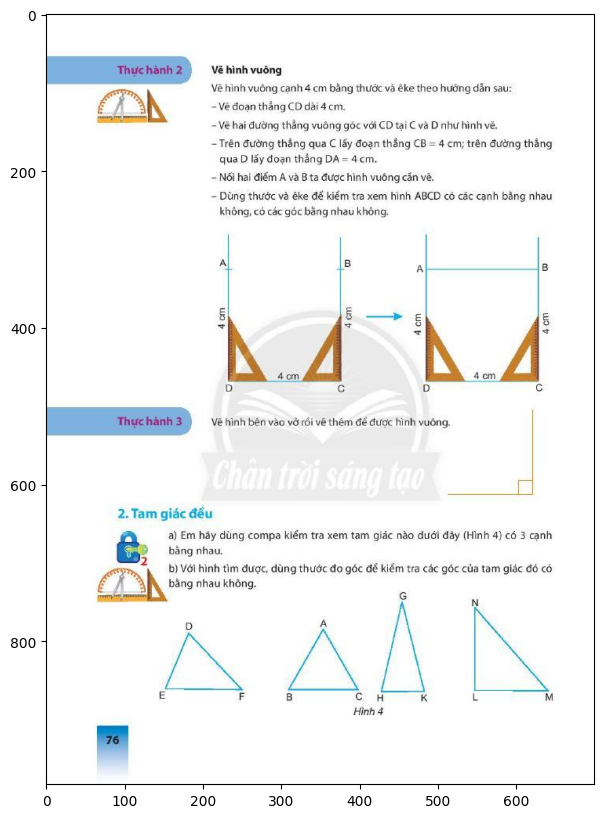

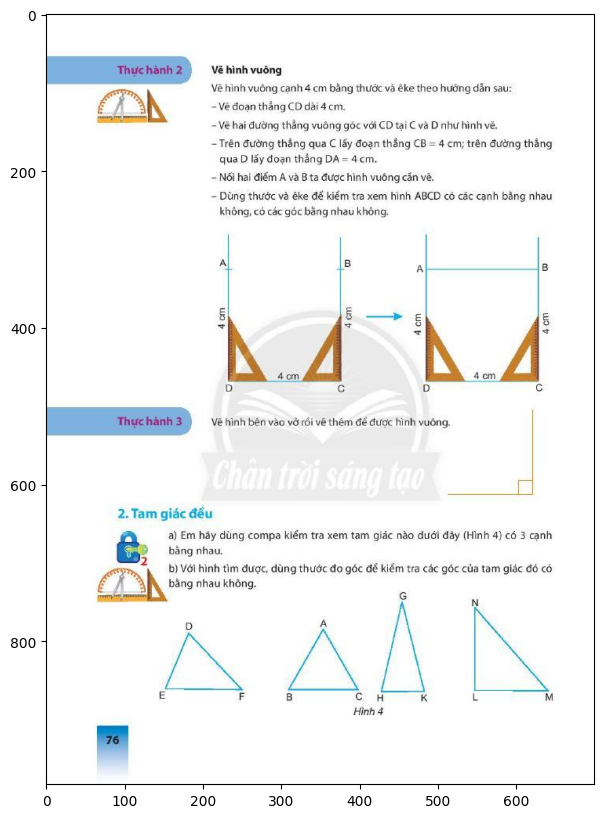

In [31]:
# Thiết lập logging
log_dir = "training_logs"
os.makedirs(log_dir, exist_ok=True)
logging.basicConfig(
    filename=os.path.join(log_dir, "training.log"),
    level=logging.INFO,
    format="%(asctime)s - Epoch %(epoch)d - Loss: %(loss).4f"
)

# Lưu trữ loss để vẽ biểu đồ
losses = []

# Huấn luyện
num_epochs = 2
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    # Thêm tqdm vào dataloader để hiển thị thanh tiến trình
    for batch in tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        image_features = batch['image_feature'].to(device)
        questions = batch['question'].to(device)
        answers = batch['answer'].to(device)

        optimizer.zero_grad()
        outputs = model(image_features, questions)  # (batch_size, max_answer_len, answer_vocab_size)

        # Reshape cho hàm mất mát
        outputs = outputs.view(-1, answer_vocab_size)  # (batch_size * max_answer_len, answer_vocab_size)
        answers = answers.view(-1)  # (batch_size * max_answer_len)

        loss = criterion(outputs, answers)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    # Tính loss trung bình và lưu
    avg_loss = total_loss / len(dataloader)
    losses.append(avg_loss)
    
    # Ghi log
    logging.info("", extra={"epoch": epoch + 1, "loss": avg_loss})
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}")
    
    sample_row = df_all.iloc[16]
    image_id = str(sample_row['image_id'])
    question = sample_row['question']
    answer = sample_row['answer']
    image = Image.open(sample_row['image_path'])
    plt.figure(figsize= (20, 10))
    plt.imshow(image)
    predicted_answer = predict_answer(model, features[image_id], question, vocab_questions, vocab_answers, len_max_question, device)
    print(f"Question: {question}")
    print(f"Predicted Answer: {predicted_answer}")
    print(f"Actual: {answer}")

In [32]:
# Lưu toàn bộ mô hình
torch.save(model, "vqa_model_full.pth")
print("Full model saved to vqa_model_full.pth")

Full model saved to vqa_model_full.pth


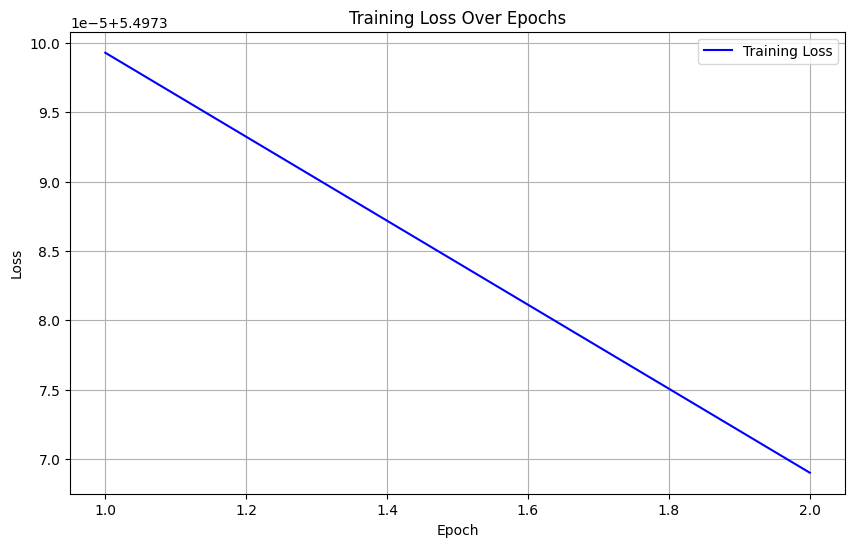

In [33]:
# Vẽ biểu đồ loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), losses, 'b-', label='Training Loss')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.savefig(os.path.join(log_dir, 'training_loss_plot.png'))

In [34]:
import matplotlib.pyplot as plt
import networkx as nx
from matplotlib.patches import FancyArrowPatch

# Create a directed graph
G = nx.DiGraph()

# Define nodes with labels and shapes
nodes = [
    ("Image Features\n(batch_size, 1, 1024)", "input"),
    ("Image Features\n(batch_size, 1024)", "process"),
    ("Image Encoded\n(batch_size, 512)", "process"),
    ("Questions\n(batch_size, max_question_len)", "input"),
    ("Question Embedded\n(batch_size, max_question_len, 256)", "process"),
    ("Question Hidden\n(1, batch_size, 512)", "process"),
    ("Question Encoded\n(batch_size, 512)", "process"),
    ("Combined\n(batch_size, 1024)", "process"),
    ("Combined Features\n(batch_size, max_answer_len, 1024)", "process"),
    ("Decoder Output\n(batch_size, max_answer_len, 512)", "process"),
    ("Outputs\n(batch_size, max_answer_len, answer_vocab_size)", "output")
]

# Add nodes to the graph
for i, (label, node_type) in enumerate(nodes):
    G.add_node(i, label=label, node_type=node_type)

# Define edges with labels
edges = [
    (0, 1, "Squeeze"),
    (1, 2, "Linear (1024→512)\nReLU"),
    (3, 4, "Embedding\n(30→256)"),
    (4, 5, "LSTM\n(256→512)"),
    (5, 6, "Squeeze"),
    (2, 7, ""),
    (6, 7, ""),
    (7, 8, "Unsqueeze\nRepeat"),
    (8, 9, "LSTM\n(1024→512)"),
    (9, 10, "Linear\n(512→answer_vocab_size)")
]

# Add edges to the graph
for src, dst, label in edges:
    G.add_edge(src, dst, label=label)

# Define positions for a layered layout
pos = {
    0: (0, 4),    # Image Features (input)
    1: (1, 4),    # Image Features (squeezed)
    2: (2, 4),    # Image Encoded
    3: (0, 2),    # Questions (input)
    4: (1, 2),    # Question Embedded
    5: (2, 2),    # Question Hidden
    6: (3, 2),    # Question Encoded
    7: (3, 3),    # Combined
    8: (4, 3),    # Combined Features
    9: (5, 3),    # Decoder Output
    10: (6, 3)    # Outputs
}

# Create figure
plt.figure(figsize=(14, 8))

# Draw nodes with different colors based on type
node_colors = {
    "input": "#a3e635",    # Green for inputs
    "process": "#42a5f5",  # Blue for processing
    "output": "#ef5350"    # Red for output
}

for node, data in G.nodes(data=True):
    nx.draw_networkx_nodes(
        G, pos, nodelist=[node],
        node_color=node_colors[data["node_type"]],
        node_shape="s", node_size=4000,
        edgecolors="#333333", linewidths=2
    )

# Draw edges
for src, dst, data in G.edges(data=True):
    # Create a curved arrow
    arrow = FancyArrowPatch(
        pos[src], pos[dst],
        connectionstyle="arc3,rad=0.1",
        arrowstyle="->", color="#555555",
        mutation_scale=20, linewidth=2
    )
    plt.gca().add_patch(arrow)

# Draw node labels
node_labels = {i: data["label"] for i, data in G.nodes(data=True)}
nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=8, font_weight="bold")

# Draw edge labels
edge_labels = {(src, dst): data["label"] for src, dst, data in G.edges(data=True)}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=7)

# Customize plot
plt.title("VQA Model Architecture", fontsize=16, pad=20)
plt.axis("off")  # Hide axes
plt.tight_layout()

# Save and show the plot
plt.savefig("vqa_model_architecture.png", dpi=300, bbox_inches="tight")
plt.close()

Question: hình minh_họa trong phần thực_hành 2 có đặc_điểm gì
Predicted Answer: <sos> hình minh_họa trong phần phần có có là là hình hình hình hình hình và và là là là là là là là là là là là là <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos>
Actual: hình minh_họa trong phần thực_hành 2 gồm hai hình_vuông mỗi hình_vuông được đánh_dấu các đỉnh a_b c_d và các cạnh có độ dài 4 cm hai hình_vuông này được vẽ theo các bước đã nêu trong phần hướng_dẫn


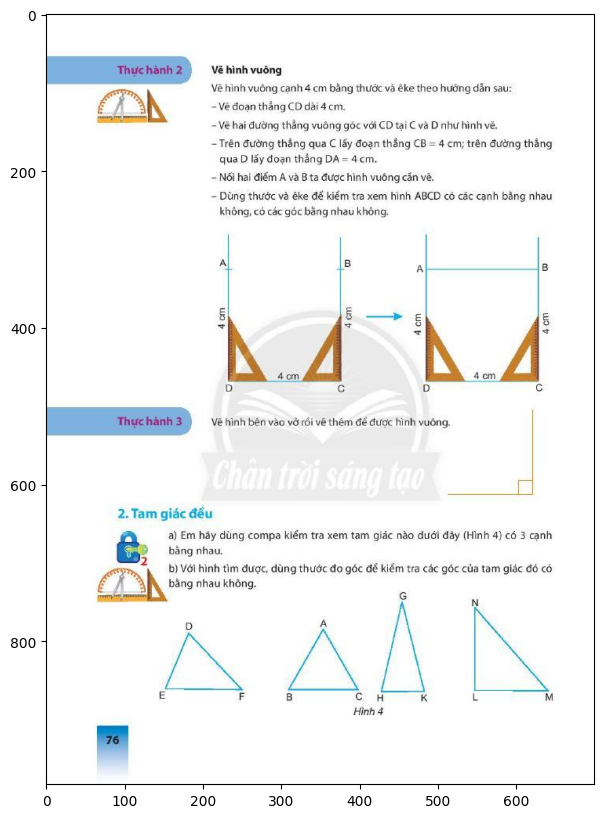

In [35]:
# Ví dụ dự đoán
sample_row = df_all.iloc[16]
image_id = str(sample_row['image_id'])
question = sample_row['question']
answer = sample_row['answer']
image = Image.open(sample_row['image_path'])
plt.figure(figsize= (20, 10))
plt.imshow(image)
predicted_answer = predict_answer(model, features[image_id], question, vocab_questions, vocab_answers, len_max_question, device)
print(f"Question: {question}")
print(f"Predicted Answer: {predicted_answer}")
print(f"Actual: {answer}")

In [36]:
from nltk.translate.bleu_score import sentence_bleu
from rouge_score import rouge_scorer

scorer = rouge_scorer.RougeScorer(['rouge1', 'rougeL'], use_stemmer=True)
reference = sample_row['answer']
score = scorer.score(reference, predicted_answer)
bleu_score = sentence_bleu([spacy_tokenizer(reference)], spacy_tokenizer(predicted_answer))
print(f"ROUGE: {score}")
print(f"BLEU: {bleu_score}")

ROUGE: {'rouge1': Score(precision=0.21818181818181817, recall=0.34285714285714286, fmeasure=0.26666666666666666), 'rougeL': Score(precision=0.17272727272727273, recall=0.2714285714285714, fmeasure=0.2111111111111111)}
BLEU: 0.010497966812227434
